## Install Libraries

In [ ]:
%%capture
# !apt install git-lfs
!pip install accelerate==0.19.0
!pip install transformers==4.28.0

In [ ]:
# !pip install bertopic # restart kernel after this

In [ ]:
# import wandb
# wandb.login(key='cc749ecdd83fa0ad0850227d24b90e0dded7e724')

## Import Libraries

In [29]:
from bertopic import BERTopic
from umap import UMAP
from tqdm import tqdm
import torch
import numpy as np
import math
import gc
import transformers
print(transformers.__version__)
from transformers.utils import send_example_telemetry
send_example_telemetry("language_modeling_notebook", framework="pytorch")
from datasets import load_dataset, Dataset, DatasetDict, load_from_disk
import pandas as pd
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML
from transformers import AutoTokenizer, AutoModelForMaskedLM
# from transformers import Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

4.28.0


## Load Dataset

In [2]:
datasets = load_dataset(
    'csv',
    data_files={
        'train': '/kaggle/input/amazon-products-mlm-dataset/test.csv',
        'test': '/kaggle/input/amazon-products-mlm-dataset/test.csv'
    }
)

  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
datasets = datasets.remove_columns('Unnamed: 0')

In [ ]:
# train_dataset = train_dataset.select(list(range(1000000)))
# test_dataset = test_dataset.select(list(range(10000)))

In [4]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [5]:
show_random_elements(datasets['train'], 8)

,text
0,"White Stitching Surrounding The Case Gives It An Excellent All-Round Finish , Creating A Professional , Stylish Look"
1,AmborisH Women ’ s T-Shirt are designed to give you a personal style statement
2,Wire-bound address book
3,Gestor de Almas : Del buen amor al buen adios
4,They also reflect your personality and lets you show off your artistic prowess to your visitors and friends
5,Product Dimensions 12D x 23W x 23H Centimeters VERSATILE and DECORATIVE STORAGE SHELVES : These rustic looking hut shelves are for long-lasting and reliable storage use
6,Fits for Realme C12
7,Sweet bear and star design


## Inference Masked Language Model

In [6]:
model_checkpoint = "RishiDarkDevil/distilroberta-base-finetuned-amazon-products"

In [60]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, pipeline

model_checkpoint = "RishiDarkDevil/distilroberta-base-finetuned-amazon-products"

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base", use_fast=True)
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint, output_hidden_states = True)

fill_mask = pipeline("fill-mask", model=model, tokenizer=tokenizer)

fill_mask('Made with Super Hard Coating and Shock <mask> technology and it protects the display') 
# actual word: Absorption, predicted: 'proof' (0.36), 'absorption' (0.23)

In [8]:
model

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [9]:
from transformers import pipeline

In [69]:
datasets['train'][0]

{'text': 'GlobalNiche Tibet Tibetan Buddhist Silver Kwan Yin Buddha Hand Statue Decoration Crafts'}

In [11]:
fill_mask = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer
)

In [14]:
fill_mask('Travelon set of 3 <mask> Squares , Neutrals , One Size')

[{'score': 0.0785728469491005,
  'token': 2156,
  'token_str': ',',
  'sequence': 'Travelon set of 3, Squares, Neutrals, One Size'},
 {'score': 0.01381677109748125,
  'token': 13769,
  'token_str': ' Large',
  'sequence': 'Travelon set of 3 Large Squares, Neutrals, One Size'},
 {'score': 0.012672793120145798,
  'token': 9513,
  'token_str': ' Table',
  'sequence': 'Travelon set of 3 Table Squares, Neutrals, One Size'},
 {'score': 0.012149938382208347,
  'token': 5041,
  'token_str': ' Square',
  'sequence': 'Travelon set of 3 Square Squares, Neutrals, One Size'},
 {'score': 0.010971050709486008,
  'token': 14912,
  'token_str': ' Mini',
  'sequence': 'Travelon set of 3 Mini Squares, Neutrals, One Size'}]

## Embedding

In [73]:
phrases = "oversize, does not represent, could be worn, feet, improved, cause helping, creating or confirming, sides, is extracted, isn, preserves, ’ re looking, to assemble and amp, outdoors, stuffed, unscrew, draining, are longing, need to, description or wrongly finished, shuffling, designed and crafted, light, reminds, to avoid being injured, twist, proudly displayed, smeet, is adjusted, maximizes, are best recommended, will create, can produce, start adding, can instantly start typing, etched, are collected, to get rid, cannot be enter, began, featuring, turned, to boot, is designed and engraved, having to remove, are working, can fill, won ' t fade , rip and shrink, beautifully made, could just find, to avoid eating, fly, shots, were, can be personalized, printed, won ’ t shrink or turn, can get started, hands, is precisely aligned, keeps, to exceed, approx, need to recreate, be used, reinforced, reducing, don ' t pull, appearing, doesn ' t happen, reflect, won ' t regret buying, originally published, argue, fully charged, sport, strengthens, designs , manufactures , and retails, to neutralize, is not overheated, can listening, please useour, immaculately crafted, formal, is traditionally made, will fits, drink, handmade, look look inspired, reading or watching, has delicately making, prevents, spread and express, unlock, to tear or snag, do not bleach or tumble, harming, download and install, sculpts, to grab, might not fit, please keep, is raised, description, mimics, will not cling, could soften, designed, gets lost, will warm, redefines, can be altered, sneaker, is carried, hose, becomes steeped, rounded, adorn, is combined, pair, cross-body, may click, meets and exceed, expands and provides, is generally made, rocking, can imagine, will display, process, figuring, to do, to shape, to install and charge, side-seamed, draw, curl, pre-washed, to determine, to help clean , maintain , and protect, won ' t make, ’ re done, heat, to use and carry, to functions, operate, are filled and floating, just insert, hang or line, dismantles, to pill, foam, would set, can repeats, chipping or wearing, categorized, serving, functioning, to slide, have also shown to have, strives torepresent, affect, vs, enjoying sitting, call, best used, authentically designed, to provides, to install and use, will see, should be distributed, include, avoid storing, coats, always avoid, built, to predict, look and feel, wasting, don ' t run, please understand, revives, navigate, can comfortably wear, reaches, value, combine to complete, don ' t put, darkening and lowering, handy to use, can give, ensured, is designed to go, has been added, have to place, becoming, can be lifted, will accommodate, mirror, saw, is also known, needing, re loved, enters, to mess, fading and aging, needs to be, been, will maintain, splattering, is embedded, finishes, are used, is handcrafted, perfectly fit and protects, to scratch, replenish, slicing and dicing, opt to bring, is not connected, to distract and occupy, won ' t clogs and leaks, want to learn, hear, are not measured, can completely wrap, convinces, is celebrated, are using, can contact, to easily attach, expecting, are deeply rooted, reliese, can also carry, can remain, massage, will not come, can be hung, type, having to worry, fixing, black, trendy, will not be duplicated, is not attached, grew, simply cut, challenges, opens, can apply, cuddling, think, ismended, do not move, relies, relieve, helping to ensure, reads, was produced, is drawn, helps create, sow, edging, shuts, want to place, will not stick, touching, don ' t need to take, fill, supplies, do not like to compromise, will answer, can be opened and closed, can highlight, forget searching, drew, is designed to keep, perfectly fit, to refresh, measuring, cannot be resold, is designed to light, will elevate, bowl, operates, to neatly organize, is recommended to order, won ' t wrinkle, being locked, like to celebrate, can easily be paired, to deliver, filled, aren, be assured, quickly rebound, are designed to help, is designed to wall, said, pleats, are packaged, is deeply moisturizing and refreshing, wants to reduce, is carefully built, to conveniently hold, needs to sow, mandated, won ' t let, believes to provide, expel, are found, draped, has always adhered, striking, are ready made, lay, has been selling, may experiment, is designed and tested, is known to decorate, specially made, pouring, can ' t be cut, does not support, are applied, to taste, travelling, must buy, depicted, to suit, are made to order, droping, is also called, are looking to click, to install and avoid, uncluttered, love to catch , chew and eat, is believing, to go wear, aim to delight, crosses, jeeps, is not covered, to experience, will help to fix, can be erased, can be added, delays, ring, can elevates, to drape, float, can keep, adjusting, skid, shorted, is specifically designed to resist, such, needs to be created, abide, saw , cut or hammer, flows, can easily see, will be handled, not stretched, consuming, spending, moving, to include, are shown, has been recently painted, are travelling, tucked, do not allow, dividing, drains, suited, are meant to be, attracting, laugh, will perfectly fit, to align, engraved, comply, can harm, to elevate, used to make, help to reduce, ve got, weighs, have become, can ' t offer, preventing or curing, can also withstand, adjust and fits, can even frame, cleans, signify, will take, will look, fuses, have been tested, must not be compared, personalized, loved to wear, formulated, capture, will be delivered, looms, will definitely add, s best suited, wash, measues, is proudly made, completed, helps to release, hand painted, completely change, develops, binding, can cover, rests, has shown, to fix, re camping , backpacking or hiking, can be served, washable, will last, to manipulate, scrubbing scraping, can stretch, simply gluing or using, convert, are introducing, cracking , denting , or leaking, to dress, to hold and non-slip, shines, is held, adapted, can simply remove, permits accomplishing, to minimize, to maintain, to update, would like to give, won ' t hurt, registered, can e-mail, can also customize, guarantee and stand, to offset, ' s made, pride, comprises, made to last, hasp, has partnered, were meticulously crafted, are cutting, reach, praising, encouraging, hand, speed, still used, to maitaincage, stylized, don ' t forget to register, goes, continues to fulfil, to looks, are rounded, accessing, guiding, shades, pills, are offered, trimming, inclined, has designed, worrying, watches, embraces, is cushioned and features, can manage, ask, are checked, do not hesitate to write, will instantly become, prevent pilling, may cause, is not designed, guaranteed to last, rubbing, are unmatched, combining, assure, is powered, folded, is designed , sourced, can be twisted, identified, propels, washed or hand washed, impresses, to substantiate, zoom, walked, will instantly add, apply note, to brew, to worry, gift, pries, satisfies, topped, to hang, are searching, reduce, provided, s, will not make, will love to wear, will enable, will also call, can be gifted or used, is fully absorbed, is expected, remember to place, to throw, supplied, can infuse, washing or dry cleaning, sunglasses, to cause, only limited, is respected, mix, is packed, simply select, masking, to filter, commonly known, is generally not hallmarked, facilate, is specially coated, come packaged, is double-printed, are completely satisfied, increases, easy control, cannot have, describes, presents, to sew, attend, may react, helps to strengthen, will go, lightly move, are always painted, to substitute, whoare, to wash and use, to resist, taken, even serving, will dramatically decorate, won ' t be tolerated, inserting, have transformed, handed, can even use, helps wick, was cut, can be easily cut, are looks, deliver, oxidizes, install and remove, is, locking, is mainly used, ’ s well painted, strive to make, are rooted, to survive, are sewn, slant, is selected, to avoid cracking, to fit bending, kick, wriggles, are widely used, can fit, aims to craft, are situated, re dedicated, will easily keep, to spook, erase, magnifying, to rinse, districtjudgessitting, allowing, coated, to buy, may not meet, can be customized, once done, help to control, kitchen, is communicated, sole, snuggle, can tear, comfortableagainst, do not include, can still enjoy, can be assured, to divination and dowsing, will not run or fade, enjoy wearing, could wear, can totally fulfill, can be charged, does not come, unite, can identify, designed to withstand, color, can quickly find and find, lined, fish, mixes, to accelerate, throughputincludes, drawing, love keeping, hosting, are also printed, item, helps promote, are belong, can be used and stored, delight, can be played, defines, vibration, to store and organize, embrace, will ensure, are planning to present, will be sent, smoothes, is best measured, tying, say, flared, can ensure, adjust, don ' t accept, to consume, can bepaired, may slightly differ, match, can easily adjust, is not included, presented, to becorrupt, will gently exfoliate, to ship, to leak, is cut and carved, hang, were destined to be, can create, can stop charging, jazzed, are hydrated , softened and protected, wiping, can reuse, is hide, ideally designed, floating, leak, will exceed, assembled, relaxing and inspiring, helps stop, has been carefully fitted, shipped, have to burn, arrange, enable, will shield, are crafted, does break, may proveide, cooking, to get noticed, cling, requirement, click, can just be, can perfectly show, pad, is meant to be, was spent, to lend, to spend, to constantly push, worship, recognizing, respect, meet or exceed, dry and cool, to easily move, paddle, affected, traveling, gather, prepare to chant, to be given, got, loving, respecting, hand embellished, stabilizing, canvas, to decorate and perfume, bothered, may be assembl, mix and match, to spell, can be teamed, will keep, is marked, attention-grabbing, are looking to be, fears, to get started, can even make, master, to treat, need to dress, to cut, can simply hold, ' re looking, will benefit, makes cleaning, swing, changing, talk, darken, serves to make, have developed, to beat, is functioning, lowering, have been developed, re not see-through, dispenses, allows to be put, lounge or sleep , work or chill, split, can even trade, ' re going to find, fulfills, way, fishing, sheds, normally takes, not included, to accumulate, harnessing, is made utilizing, travel or go shopping, s meant to last, securing, must choose, is generally used, identifying, couldn ' t fully protect, branded, ve selected, latex, helps to develop, do not represent, solid, do not store, completing, have been looking, are wrapped, to fold, can develop, can customized, attract, taste, align, is sewn, looking to target, jointed freely based, suiting, outlasts, features, ruched, thread, want to add, to return, are taken, is endorsed, are selecting, can easily wear, to paint, peeling, are shaped, to further enhance, to hit, studying, fully extended, battling, encompasses, minimizing, to assist, should be treated, is headquartered, supporting, instill, to think, will do, to embrace, rug, is not going to vanish, signifies, can effectively reduce, manufactured, developing, unblocks, invest, ported, launders, moving and damaging, to visualize, smiles, can envision, is buzzing, are provided, will stack, helps to revive, to flow, stopping to grab, don ' t cut, writing , typing , and using, dyes harming, aspire to compliment, are usually made, infecting, resists breaking , cracking , chipping, can easily pass, further adds, may have been, extensively taken, can block, been crafted, place, will disguise, to relive, to roll, ' re wearing, to complete, have to think, to grantee, to removed, has been given, will use, want to wear, to mix, may also try, to perfection, do not use, may lose, extensively used, do not twist or hammer, sew, piping, loves to carry, is also designed, are attached, will fit, re going to find, lend, should be rewarded, checkout, helping to save, might take, eliminating, will pack, may occur, fabric, allow, grips, have been, properly installed, will teach, profile, are devoted, can damage, s always welcomed, to lose, to be refunded, will compliment, do not hesitate contacting, to fetch, can check, control, to heat and serve, do not get faded, shop, has been handcrafted, to breathe and flex, log, is specialize, measures, step, ’ ll love, are stitched, could also mix, shown, uniquely made, is controlled, is hand made and hand painted, uswe, developed, have listed, will strictly adhere, helps extend, envelop, gold, precisely crafted, is best used, are excited, will love finding, is enhanced, strengthen, specially designed to fit, need to be, is twined, playing or hiking, must do, can record, grabs, please refer, paint, reconnect, splashing, to enjoy, to be stretched, scoring, may not stick, will not to be damaged, is not properly stored, will definitely click, s paired, to gets, amplifying, are hygienically packed, is highlighted, free, soak, can be clubbed, darkening, can remedy, bending or scratching, try to change, designed to give, being made, packagechoose, do not scrub, to wear, are going to work, need to replace, needs to be removed, celebrating, will not work, noted, have been traditionally regarded, note, will not become, to start designing, entered, being transported, try and offer, designed to improve, has been designed to grow and is, want to pass, don ’ t need to be, are designed to keep, liven, highlighting, is also backed, surrounding, closes, decorating, could reach, to adjust and flex, shoot, can effectively resist, can be floating, has been repaired, flipping, can cause, may show, to mimic, burning, repairing , replacing or making, served, toughening, to liberate, to diy, adapt, to get used, will also strengthen and hygiene, have, will worry, are composed, lessen, detangling, is guaranteed to elevate, cherich, survive, sacrificing, re constantly focusing, figure, stretched and framed, manufactures, have confirmed, scratching or chipping, could use, have been preserved, filtering, to meet, need to screw, will never feel, calf, won ' t drip, suggests, pairing, to provide, binds, outgrow, to be, to replace, to drill, engaged, are completely protected, raise, decorates, have been cut, ’ s specially treated, resist, to access, will not be affected, repairing, can be positioned, ruching, will, enhances, could pair, can fold, has produced, lock, is also pre-drilled, deals, to adapt, to be considered, will discover, ' t touch, can load, fusing, travel, are balanced, sign, will uniquely dress, are fits, will differ, can draw, exclusively designed, straightens, freshening, is combining, painting, can evenly disperse, can set, will complement, to remove dried, reiterates, stoles, design and build, don ’ t hesitate to turn, to be placed, rent, remember and choose, could be, do not affect, helps to keep, neat and clean and put, needs to be charged, supervise, minimize, have been stitched, can be rotated, are confirmed, won ' t fall, opt, isn ' t just intended, can be maintained, strategically located, impress, gushing, is ergonomically designed and aesthetically appealing, m, to swing, can not only be used, exude, could be configured, are hand made, can rotate, exist, is suggested, symbolizes, sources, clarifying, open, will not expose, root, smelling, bedroom neat , tidy , and organized, is cleverly designed to be, may be required, attach, buckles, will put, could organize, compromising, cover, wrinkle, brews, email, s have, can accommodate, is designed to interface, to finish, to help prevent, can be placed, can also make, is advised to make, swapping, easily install and remove, are consumed, reminder, will perform, please trust, would correspond, is looking, will require, relaxed, ’ re, prepare , and cool, chase, encrusted, knot, organized, housed, nourishing, is attached, believe, may not be, previously known, install, sewn assuring, please email, to understand, exuding, can guess, s supposed to, can always send, begins, helps to combat, is properly named, shaping, desire to add, showing, can dual, can design, mixing and matching, wouldn ’ t take, divide, are washed, are kid-tested and approved, lose, is also designed to help keep, get used, night, is being specifically designed, carefully wrap, is better transmitted, to be used, s drawn, absorbing, swear, properly cared, guarantee to resend, to blend, s printed, to daily wear, closely contouring, have skilfully raised, sip, sleep and relieve, help protect, quickly disperse, would like to invite, is also won, be reminded, is checked, to carry and assemble, to make, realizing, sit, can to make, can also be fit, viewing, does not get caught, help turn, is designed to perfectly fit, hang to dry, picked, can also give, will hence prove to be, preserve, to interact , create and edit, recommend ordering, webbing, voicing, is first stained, to grasp, can ' t slip, can be adjusted, scrunchies, regarding, lessens, hears covered and heated, fully absorb, doesn ’ t require, was known, love throwing, to carrying and saving, beautiful, do not sell, do laser cut, are always dedicated, pigmented, alternates, stick, is widely used, then put, cotton, covered, will stay, glow, to build, are made to be fitted, to warn, can also paste, will love having, printed and shipped, makes, to gift, effortlessly apply, can sit, pewterintroducing, to install and remove, release, to receive, has long been used, to turn, are cut, were founded, does not get, does not slide, coming, can lead, should be, can be prepared, are polished, to protect, support, are integrated, slanted, are served, search, is frequently used, have increased, will love coming, can be lowered, is then alternated, weigh, rule, can to create, to glamorize and achieve, to confirm, to use, designed to meet or exceed, dock, is hung, cradles, can switch, to refund, starts, are buying, wanna, are missing, deserve, to eat, choking, do not clean, are awaiting, are showing, to occur, can be collected, can put, is focused, prepare, then stapled and taped, is meant to produce, to combat, are fully drawn, inhabiting, to invest, might need, to easily fit, to reset, looking to add, to light, is carefully formed, gently wash, will always deliver, were strategically placed, helps ease, frantically flicker, would do, need to look, pour, does not have, are made and printed, could be easily sticked, can turn, can live, measured, held, melded, determines, recmmend, clasps, to clean and maintain, center, be, innovating , developing and bringing, can be mounted, is coming, to hold, rust, is spreading, will be surprised, are then used, leverage, can see, to add, underestimate, is unstitched, promised, grant, pleasecarefully remove, acodating, personalizes, can be removed, freshen, sitting, burn, will not mar, toss and turn, illuminate, can gracefully and beautiful, should avoid washing, fitting, can boost, always be, not only serve, combined, to maintain or clean, does not yellow, may have to face, pressing, have lost or broken, to be admired, was established, will surely fetch, is grown, holds, groom, knob, can ' t be, may also be, don ' t search, also packed, to delight, to be kept, will spiff, bought, will be thrilled, is developed, to usesimply pour, will decorate, to install and replace, is hand-stretched, save, have been aesthetically made, is ought to only be used, flatten, would begin, may get, transmits, grades, locate, worth, is delivered, can be reached, can never ignore, can be cut, is kept, shipping, reopen, revitalize, to contact, could be removed and installed, to mail, is unmatched, don ' t waste, can be written, can capture, will not discolor or fade, personalize, tempering, please kindly view, warmed, easily handled, been sold, are passing, relax and rejuvenate, concealing, please order, are ride, to wake, stops, to snap, demands, replicating, warms, has been specially made, can effectively prevent, lies, wanted to be, need to protect, back, thrive to bring, has reforced and sewn, inlaid, compliments, can be quickly hung, don ' t self-disassembly or puncture, graces, monitor, saute, casting, showering, left, can totally make or break, would find, scoop, circulate, has to be sliced, drinking or storing, can confirm, to feel empowered and inspired, contains, was overlooked, will always be, to tuck-in, do not have, can provide, bristles, can not be, waits, could fit, establish, is tilted, impacts, serving and packing, calculated, emits, to be wasted, is suited, tie, jogging, will enhance, guaranteed to fit, rotates, to monitor, is specially handcrafted, is professionally printed, is individually molded, feedback, will refund, watch, selfies, please let, weave, to design, strive to produce, adapts and molds, will repel, disturb, can order, will not add, grown, must have, won ' t miss, unveivx, to support, name1, coupled, starring, is extruded, would not be, are inserted, are serving or packaging, imparts, to paste, is to be printed, to help pump, do not repeat, freely and relaxed, can relieve, will not only help, toy, teasing, can perfectly buckle, ' re working, attached, usethe, proves to be, are designed to absorb, to match, seals, storing, selecting, may be used, digging, optimized, restricted, forged, is been waiting, to quickly hide, is believed, canceling, drilling, balances and clears, thrives, should be approx, please, are specially designed to make, will liven, maintains, needs to be glued, is paired, lace, pilling, can glow, circulates, wish to bring, to better fit, turns, now need to grow and develop, do boast, can choosing, can also come, keeping, is offering, have always been, travels, can be treated, to be made, to make or break, to power, helps regulate, to lock , unlock and extend, are guaranteed to deliver, designed to bring, can be rolled, is pressed, baking, do not drop, will hardly bring, does not catch, will retain, please carefully check, are being delivered, happen, shielding, are then professionally box framed, to kill, can be installed, select and order, loves, scratches, deserves, are completely glued, slides, need to beat, are expected, lure, is allowed, roll, don ’ t want, affects, was first proposed, protects and cares, can enjoy, is bursting, deform or break, exfoliates, re-inventing, does not rust, is sized, were deputed, to recreate, to style, need to remove, to express, boil, combed, instigate, won ’ t occupy, helps, don ' t feel, will surely impress, breathe, are to receive, has been completely remade, sink, are exploring , learning, containing, to be reholstered, designed to compress, updated, to mention, won ’ t miss, is causing, are featured, spying, are reproduced, gripping, fascinated, included to protect, to attend, to install and slide, is so much appreciated, can fulfill, will come, studded, are dispatched, to wipe, will change, prevent splashing, retaining, needs to be pushed, to pamper, to enhance, seems, will enjoy creating, are easily removed, to link, regains, identify, inserting and removing, can be easily taken, threaded, rubbed, can solve, will also save, would be made, comb, don ' t, remind, can be easily and securely closed, to clean and disinfect, will never go, can be interpreted, lends, ’ re driving, decrease, replacing, to cleaning and wash, sizing, practice, test, shock, will stand, happens, fix, will want to even wear, sexy, suppose, les, is not stuck, trims, once installed, running or cycling, had, revolve, wash or dry, to activate, lifting, are built to last, to head, clicking, help to protect, to easily insert, hiking, will surely keep, feature, seen, to package, painted, can get, re-create, will not be distorted, can diy, guided, to squeeze, love communicating, can easily hang, tightening, can choose, long, clears, will not face, will hugs, designing and crafting, are connected, can pick, cushioned, has been manufacturing, blink, goes to help, is uniquely designed, to make grabbing, neatly organised, can write, drive, completes, can be washed or cleaned, boasts, underlie, publish, resists shrinking and fading, notes, sometimes seen, ’ re not thrilled, should be complemented, captures, is doubled, hide, can understand, retracts to fit, collapses, slots, will twist, may take, can stuff, to integrate, trending, can handle, favor, don ’ t end, can install, will also fit, are technically designed, wipes, starts warming, protect, hand crafted and hand painted, has advanced, will contain, empowering, premiered, even serve, is affixed, are manufactured and designed, will not only well protect, to pre-cool, to inject, to practice, will never fades, helps strengthen, to air and deodorize, share, supply, can find, will relish, to carry and doesn, feels, is applied, trusted, to relocate and display, specify, will revert, to increase, to rationally allocate, tight, can search, feel and look, do not bake, padding, aren ’ t scared, cannot do, relish having, spread, gluing, could be used, has been named, want to deliver, doesnt fade, always have, is permanently attached, was updated, specializing, stabilised, rendering, ats reserved, is processed, will work, to have, drill, to flaunt, may use, is found, roasted , grounded, help cushion and showcase, rebuilds, to easily remove, puzzle, are designed using, sensing, is protected, wiring, insert, can generally be cleaned, laid, wanting to share, brightening, will rise, has been checked, can be easily changed, doubts, aim to produce, does not look or feel, is elegantly crafted, affecting, creatively lacking, to stash, is designed to do, to gently stream, to perfectly compliment, guaranteeing, designed to take, will also love, re-apply, to comprehensive protect, to damage, to not affect, reveals, are drawn, aim, changes, stems, will have, touch or touches, want to order, get, bag, care, stabilizes, are designed to statically cling, stir, should be surrounded, are now experienced, scroll, needs to, phat, is best worn, are not only shaped, will ever own, does not slip or smell, hurts, record, authorized, adapting, will stall, to perfectly match, goes missing, to care and clean, going, scrape, bounce and uncomfortable, cars, repair, ensuring, can be carried, augmented, are double-protected, doesn ’ t get, worry, will charge, are artistically created, to day use, intended, please help keep, can watch, were looking, are evenly separated, s actually made, to be applied, will help to reduce, to mention being, won ' t get stuck, can be kept, can also show, want to increase, has grown, becomes, want to find, can be opened, thus give, helps heals, strives to bring, impacting, shut, hit, chose to conduct, is being used, continues to grow, want to tidy, can be poured, to open lid, represent, live, writes, to bring, cool, to play, to avoid scratching, suits, ve embraced, separate, then printed, break, won, never fade, to unveil, file, stunning, safe, intended to protect and comfort, sweatpants, can meet, shall be, can refer, do not dry, pressed and deformed, tried to establish, textured, is streaming, aged suffering, chatting, adorning, to install and pop-ups, dream to make, write, can be easily washed, will help to decrease, to last, will cushion, are held, cannot be supplied, always stay, can fall, ordered, shift, pursues, join, to develop, to come, rolled, to wash, to equalize, was not only designed to conveniently fit, charging, can compare, avoid spilling, have undergone, can store and organize, bounce, safe guards, encourages, screw, is not considered, is fabricated, can also put, may, giving, can be directly washed, guess, to fly, including, is completely equipped, ’ re admiring, makeover, promise, may enjoy, adorned, have been applied, near, characterizes, slips, to restore, refresh, is given, will beauty, is only achieved, to comfort and adorn, obstruct, is blessing, thrown, cross, advocate, earned, takes, will never drop, can double, doesn ' t get unwrapped, integrating, performs, ix, dropping and shocking, come backed, prior, are infused, can ' t adjust, putts, driven, are designed to be, comes, trim, assuming, settings, can easily slow and maximise, can be stored, renowned, has been producing, are well finished, just starting to play, will not split, can be set, quik, to wall, will harden, is unfolded and mounted, hulls, to trained, don ' t want to get stuck, assorted, neatly organized, has come, are fitted, providing, can be use, reed, can move, are lined, reflects leaving, can really make, hugging, groove, was appointed, ’, apt, prides, is binding, setting, are meant, can save, will not following, don ' t paint, to help keep, can be wired, can fully fit, have appeared, is intricately carved, dry quickly, is revealed, being washed, keep to stay, will never get, to stretch or wear, tipped, reshape and dry, lounging, varied, are produced, will avoid, like to move, are not provided, insulates, being exposed, did, destroys, is been designed, could easily organized, handmadecrafted, subtly polishing and brignten, fi nds, destroy, can bring, prefer, wrinkled, scratching, belive, born, ', agree, is designed to make, is just keep, to cover, must be kept, can be worn, to purify, can be easily used, are modelling, are sanded, sweater, do not wash, can connect, will really enjoy, softly warm, brithen, can be sliced, to guard, lived, cupcake, to load, to easily raise, seeking, edges, is meant to resist, are needed, wear and tear, will love, can also search, won ' t fade, shelving, will end, shared, explaining, designing, wicking, can replace, order, carved, recharge, improve, to tug , touch and chew, prey, weighing, ripples, raised, to select, is exclusively designed, doesn ' t include, recommend to use, will not do, exceeds, can ' t hear, s made, can be opened-closed, summon, jungle, acting, switch, helps prevent, embellishing, to rotate and sturdy, was designed, no need piercing, has known, can be gift, gain, wanted to, exhibit, is composed, will help, long lasting to ensure, trimmed, to socket, flies, could aslo built, brushed, may be seen, emphasize, can be easily removed, drain, can order and check, loaded, need to worry, heals, strives, to compress, does not feel, handles help, laminated, to use and install, should check, purshase, give, to wear and tear, bringing, flushing, do not iron, expands, can locate, is retained, will not go, can creat, is complemented, to get complemented, prepping, secured, resulted, is set to become, multicolored printed, wont absorb, exhilarate, jazz, to stimulate, can add, can be fitted, do not bleach or wring, barbecue, bake, would disappear, teaching, names, desired, to install and remove and shields, can be, can be easily recognized, pick, smocked, separates, can ' t bring, to hurt, will start to flash, will give, can not penetrate, sculpted and wrapped, is measured, illuminating, to feedone, classic, narrated, will never regret, ’ s creating, looking, to captivate, saving, directed, ll love, has been applied, wishes, to illustrate, will not fray, bearing, described, rose, can ware, to refill, are set, places, correcting, will not damage, producing, can be carry, can also use, relish, s just produced, closing or sealing, are not included, will not curl, have been conceptualized, do not cancel, hung, handcrafted, solving, can guarantee, sideways, to comfortably enjoy, brand, sporting, can also accept, seeking to unleash, have encountered, are located, to compete, is characterized, cause, shank, safeguards, invite, wake, will ultimately make, start placing, is put, will improve, doesn ' t have, blow, can vary, speller, doubles, relate, begins to communicate, have been hemmed, is designed to penetrate, is diligently handcrafted, stretching, click and connect, to prepare and touch, can speak, frames, reading, don ' t satisfied, delivering, customize, pose, are stylishly designed and produced, to send, converted, concentrate, is happening, seduce, being scattered, will place, has proven, can also be worn, skin, won ’ t leave, tempting, purifying, completely changing, help to add, related, helps protect, to flex, are happily looking, used to actually print, design, are hygienically processed, charges, discard, strive to innovate, is optimally designed to fulfill, will be printed, have been highly favored, needs to be cleaned, can brighten, please take, feel fulfilled, followed, promise to design and produce, contours, helps generate, re making, cooling, can be easily wiped, dedicated, drape, introduced, achieving, braided, to detect, showcasing, will definitely love, handling, is wearing, later expounded, is created , designed , and manufactured, halters, ve given, already attached, switching, just put, to fight, are manufactured, helps reduce, comes already perfectly stretched, cannot be bleached, cushions, is guaranteed, request, complement, to train, to reduce, eat and drink, do not hesitate to contact, then help, is fused, love to grow, do not place, holding, spells, is equipped, also used, dipping, causing, recommend choosing, is made to be, unstitched, to feed, is assembled, granting, vent, accented, are not fully satisfied, having to constantly worry, are continuously inspired, integrates, doesn ' t fit, washable and dry, dispose, injected, to stock, last, knitting, can well decorate, are not using, hidden, could prolong, may not support, is brought, checked, rsquo, might had, wash recommend, simply tell, agrees, clogging, ' re headed, glows, are replacing, quick drying, try to keep, boiling, are intended to be used, have reworked, exhibits, affords, could never work, are actually ordering, is first being sourced, playing, perfectly fits, to provied, will help protect, decided, damped, close and maintain, molded, usher, rendered, can sing, is assigned, can be matched, shoes, consider increasing, help prepare, don ’ t have to compromise, expels, simulates, cutting, folds, can automatically identify, to disinfect, has portrayed, then plated, please kindly check, then placed, hasn ’ t had, managing, committed, might results, can greatly change, would have otherwise faced, will feel comforted, are proudly made, kids, can inform, is stretched, can return, backed, dreams, have to be protected, installs, to keep, leading, brushing, eventually grow, can be re-melted or poured, will cover, laminated to last, can protect, remaining, invaded, waisted, select, durablemeaning, are exposed, can easily install, never fall, should order, smooth writing, cutouts, to and use, can arbitrary, will definitely show, lifts, are powered, wear and sleep, drops, does not affect, to assure, want to apply, referred, varies, to correct, don and rsquo, move, to highlight, breaking or deteriorating, limits, wraps, not come, can not only serve, bonds, strive to stand, to open or close, is moving, helping prevent, will open, reinforces, please expect, regain, are designed to pack, are certified, will helps to extend, can be best teamed, to optimize, allowed, upgrade, opens expanding, will hold, not only pollute, may thicken, avoid rubbing, bathing or swimming, are equipped, lowers, to safely store, revering, designed to resurface, screwed, cleaning, sticthing, to mold and stylize, fades, may want to consider hiring, equipped, combat, depicting, recommended, mixing, satisfy, has never been, smudge, pure, requested, disinfect, finding, stitching ensuring, can be also be used, will definitely help, can adorn, crush or twist, deter, meet, to fall, chairs, might think, can contain, can press or squeeze, are dedicated, has been fantastically crafted, define, will allow, can be bought, answered, to be distorted, will heighten, to relish, to browse, magnifies, has been condensed, stop wasting, can be applied, worried, hurt, refilling, ripple, coordinating, can be stitched, to preset, help deliver, do let, strap, to change, specially colored, can prepare, ’ re going, offers, are beautifully designed, can adjust, does not need to plug, damages, would normally be, sell, is not only known, detailed, is known to be, sprinkle, will be shipped, racing, even keep, amplify, to accessories, has earned, rinses, embossed, selected, to carry and protect, to disassemble, to clean and dry, must be installed, are precision-measured, will produce, to color, wake uncovered and cold, was taken, knowing, scalding, combo, sintering, are glazed and baked, broken or lost, boasting, can easily pile, has also completed, barefooted, elevate, won ' t bend or break, highly detailed, want to bring, beautifully crafted, designed to work, lengthen, has been enlarged, will be given, enriches, does, can be re-positioned and reused, mat, grow, were made, waver, has been taken, specifically designed, forefoot armoring, evoke, is built to last, not blocked, comprise, cards, is adorned, easily operating, admire, to freeze, pioneered, wicks, pre-heat, pinning, transforms, also saves, analyzing, cushioning, can ' t forget to praise, is pulled, won ' t experience, are designed to resist, can be easily integrated, need to keep, to organize, folding, bid, making, clean, need to shine, opening to fit, carving, can even shave, aims to give, want to style, continues to offer, are embossed, is receiving, is ranked, can also be gifted, will surely spark, have evolved, need to complete, can be folded, welcome ask, will not cause, decorate and accent, to be washed, enter, can best release, acts, to easily separate, blocking, flow, prevent, to exercise, stranger, asked, scrapping, is renowned, kept, ' re not fully satisfied, can press, are required, can disinfect, ' re, crafted and proudly made, has been creating, are devote to provide, can get mildewed, mashing, to makeover, conveys, can iron or steam, depend, stimulate, tablets, has adhered, dyed, welcome printed, are choosing, are permanently embedded, to achieve, will be answered, can be recycled, playsuit, love to see, will not fade, to smooth, to attain, to measure, wash or handwash, to stretch, will definitely create, anodized, to fully adjust, declare, close, helps to cool, created, need to lift, carpets, pans, do not easy to lose, boost, own, are based, is missing, to put and remove, stood, hard, doesn ' t change, scratched, bolster, are absorbed, are properly sized, source, hase, need to consider to add, employing, will dry, has become, to limit, remain, are specially designed, will develop, attaches and holds, avoids, zip, can also cycle, is inside, redefine, are known, resisting, may even be, arise, to convert, reflects, filtered, possess, will get subsidized, has added, doesn ’ t shed, to still allow, to resolve, waves, lacquered, spotted, can shoot, could fixed, organize, approaching, have been created, are providing, do not worry, is handcrafted and made, brew, is keeping, even soaking, should be maintained, is designed to exemplify, can reach, gained, commonly used, cracks, coordinates, tighten, ture, expressed, not compatible, is lined, experience, packed, can caters, are dried, can hold, will drape, try to delivering, not include, are carefully designed, backpack, hiking or travelling, to put, will appreciate, highlighted, deserve to sleep, safeguarding, will support, set, is softened, indulge, have been crafted, strive to be, extend, lines, to produce, rolling, spout reach, to fulfil, enhancing, will help to develop, parallel, will damage, awaits, collects, send, are designed to give, to help lighting, have to worry, charge, to keep flies, pave, originating, have occurred, shampooing, to sweeten, will fall, defeat, can click, to evenly distribute, to armpit, allow to air, designed to comfort, surfing, has been made, designed to offer, passes, has been proven to lead, hopefully unlock, bending or breaking, can also accommodate, exclusively designed to match, won ' t strip, should be wiped, should know, knows, is dedicated to build, ’ s raining, ], enjoy displaying, immerse, can be firmly fastened, should expose, plugging, is specifically printed, go to protect, to keep airs, to run, may seem, are loaded, develop, will be shine, are strategically placed, can charge, attaches, are recommended, can easily pair, would not want to miss, will certainly be satisfied, will ve, accelerates, crystalized, evenly distributing, plug, can feel, growing, repels, brewing, wear, are not helping, will not wrinkle, to craft, are formed, want, will linger, is shipped, not tested, won ' t be disappointed, pleated, perfectly designed, would try, to open, output, patio, to control and determine, to prepare, fully assembled, is infused, don ’ t need to change, protected, canuse, do not require, fills, to explore, don ’ t need to worry, walking or running, plans, gifting, start putting, block, adding, stitch, hooking, does not cause, is not returned, will surely add, placing, droping and give, is making, to expand, are easily cleaned, produced, ornaments, could be taken, are only limited, gently release, to display, destroying, will not scratching, melt, touches, enjoy, to manufacture, sewing, rejuvenate, to attract, getting, can measure, touch, breathes, exceeding, helps heal, would love to solve, to execute, don ' t have, polishing, can be supported, ruining, iron, sacred, selling, have been enriching, communicate, will not only enhance, run, not intended, to subtly grace, named, want and keep, to stuff, getting wasted, coordinate, have been affected, can be stacked, does not contain, goes will, can be layered, don ’ t have to choose, must be met, has been developed, are dyed, well known, will also protect, to install and clean, avoid using, do not return, can be reused, is added, specializes, has been shaped, keyed, sinks, can also be served, naturally, passing, beautifully designed, travelled, to prevent slipping and tripping, offer, is designed to be, to follow, to cook, visit , or nap, are manually measured, looking to elevate, is assured, re washed, joggers, scooping and serving, to withhold, can also be easily snapped, is shown, sounds, ' re satisfied, causes, re still family owned and operated, are made to be worn, please write, to has, to celebrate, is supported, saying, can often be, remotely reposition, to properly care, gear, is skillfully handcrafted, donâ, are wearing, does not deform, could gently remove, rub, to remind, will respond, cover to protect and make, can be converted, appeals, landing, are smashing, waiting, to water, to try, won ' t be, do not usually have, draping, will fulfil, do not overturn, will also attract, carefully crafted, works to stop, ' re excited to offer, has uniquely engineered, ve invested, want to ask, specially crafted, sponge , never rub, can fix, does not need, undergoes, to handle and storage, happing, to exude, wearing, withstanding, potting, based, are widely demanded, customizing, will not be match, would also love to wear, brings, is extensively used, might keep, driving or seating, trekking, will safeguard, is organized, to solve, helps get, is recommended to wash, has also saved, jot, don ' t harm, slipping, are going to take, stay, packaged, designed to fit, differ, can sew, are holding, wriggle, may varies, need to lead, required, re finished, is to be, don ' t wrinkle, circulating, also known, to check, product, will redefine, notedo, are bringing, following, can be read, loves to wear, squeeze, verified, tone, is double glued and blind stitched, having to drill, will not be, will imagine being, sculpting, to lead, to slip, do not spin, can pour, churn, detail, specifications, do not confuse, scale, have been designed, head, can be easily accessed, to breathe and wick, can beautify, meets or exceeds, may wash, participating, heeled, to thoroughly clean, to accept, placed, should not exceed, compare and contrast, to satisfy, will be amazed, involving, will alert, to germinate, is fashioned, matching, face-down, can mount, don ’ t have to worry, to floor, to benefit, can affect, don ' t fit, re not kidding, can ' t miss, cultivate, promoted, fading or cracking, to email, rigorously tested, aren ', has impacted, wrapping, will also never sweat, to forget to give, moisturizes, leather, doll, to evolve and transform, has undergone, to handle, must be, can well prevent, long lasting, contain, do not put, searching to reconnect, can only be used, rinse, will not ruin, can now, to believe, is calssified, is said to release, to become, shields, can suggest, conceptualised , manufactured and shipped, to perfectly fit, rest, could move, gobehind, will be adjusted, started, are associated, may look, do not hurt, involves, are adored and respected, to tackle, being fully suited, will bring, was posted, trailing, may have occurred, find, pack and ship, can be spotted, portrait, says, express, read, also enhance, to have heard, to extract, frac12, to download, wastes, has defined, jacketed, ’ re craving, strewn, is also recommended, always believe, cheering, ve found, tracking, suffering, nail, to gently sand, adheres, endorses, wring, meaning, to serve, easy, need to cut, are getting juiced, can locked or unlocked, can be strung, do not irritate, have always had, may cook, peel, grows, wash recommended, shake, plated, reduces, want to remove, is built, do not taste, shaping and defining, glue, cool and prevent overheating, accept, is combed, will gave, love to accessorize, hindering, to always buy, teal, realize, widen, are perfectly tailored, should definitely get, to work, hitting, marks, are hosting, examine, style, rugs, releases, resists scoring, to expect, does not reduce, storing and draining or drying, may vary, have handcrafted, exercising, reclaim, flatters, can easily carry, can visually make, to prevent and treat, is pre-shrunk and bio-washed, absorbing and dispersing, applied, damaging, need to get, will choose, needed, may exist, launching, will also share, are utilized, to yield, to raise, bursting, can relax, harms, disturbing, also help, train, can therefore deviate, can arrange and organize, is not affiliated, just remove, to install or no cutting, displayed, stepping, will resolve, to tell, are constructed, can achieve, to promote, postulate, to pickleball convert, can withstand, to effortlessly provide, spade, will guide, aid, is decorated, shows, ergonomically designed, cleaned and placed, stitched and stuffed, translates, connecting, to read, brass, to finalize, primarily used, presenting, heard, to modify, nests, requiredpre-fitted, not smile, change, introduces, can expect, can be easily mounted, may not match, grip, is being produced, suggests going swimming, framed or unframed, to nicely cover, brace, were proved to be, frosted, can easily fit, fiddling, will lend, ties, do not add, must-have, ve been dedicated, want to relax, can be bent, molds, wish to remove, odysseypursued, wants to do, was not built, flaunt, to soak, to fender, is layered, swathing, also gives, naughtily winking, do not pull, falling , fully protect, to smooth and refine, burn clean, can layer, has put, promises to keep, argued, detects, lying, not tried, wont impact, has got, glued, to cleanjust take, don ’ t use, will protect, doesn ' t, will not need to purchase, enhance, to workout, to easily watch, does not make, to not look, breaking, adore, rigged, can send, manufactures and supplies, whats, excel, maximizing, want to go, has had, will impart, can be delivered, stride, should be adjusted, does not absorb, are encouraging, wondering, known, have have, to empty, is committed to deliver, will be provided, can be woven, embellished, led, pot, are trending, paired, approach, resolves, are fixed, is guaranteed to be, generally have, construct using, resonates, like, guarantees, subtract, captured, won ' t help, can choke or suffocate, s strutting, bean, don ' t need to worry, to look, raged, to waist, has found, to assembly, won ' t splinter, refract, bedspread, helps utilize, laying, to copy, to adorn, undertaken, treats, less traveled, bring, is based, hopes, facilitating, doing, continues, is made to fit, thats, should be put, worshipping, 1-click, highlight, normally associated, are decorated, to change or match, are packed, flooring, s been, to boost, can be returned, perfecting, covers, want to personalise, need to outfit, can never have, are carefully inspected, recommend pairing, wrinkles, can help to decorate, to write, forget to switch, recomended, published, should pay, muscle, can go, discovering, can not even imagine, should own, can be done, pin, footbed, will not bleed or transfer, do not apply, is highly appreciated, don ' t be, infiltrating, backdrops, stuffers, to tie, s been reinvented, aiming, teach, leveraging, aged, to distribute, matched, are designed to spruce, to charge, are built to deliver, might note, want to look, slices, sponge and wipe, can only be purchased, design and curate, are thoroughly subjected, ooze, can make, have elected to bring, authored, creating, doesn ' t effect, to ' wow, rounding, easy-to-carry, hamper, can be observed, carries, upholstered, may not be delivered, have decided, eating, do not scratch or damage, will provide, would be required, can be said, solve, ground, inserts, stringing, try, will never make, written or authored or edited, to also help stand, puts, to present, stopping, drying and storing, to mind, is not fitted, promise to bring, ' re looking to get, accumulating, can wash, simply pour, can stylize, is shining, prefer to use, to forecast, help reduce, may also have, to methodically store, migrating, subsides, socks, can be easily re positioned, feeding, is also offered, boast, stain, helps to hold, can also be applied, needs to protect, consider to buy, do not dryclean, aids, can be re-used, to e-mail, report, to interfere, to drive, to effectively train, retains, are shown to be, combine, can also pair, are finished, means, s suggested to wait, hesitating to buy, love to show, secures, are examined, have to stop, specification, no need to use, do not bleach or dry clean, knitted, attaining, pulled, continue, may send, collect, love, mention, carefully unfold, reaching, can be assembled, to be connected, resin, do not offer, optimizes, recommend doing, can also be given, well made, to energize, can increase, can help, can ' t find, track, is observed, soothe, accessories, please allow, could also provide, can plug, can do, to give, is stored, has gained, packaging, meditate, push while traveling, is carefully ironed, transfer, start exploring, is matched, has been designed to be used, is riddled, lasts, recycle and help leave, to flash, to break, molding, sale, comes already framed, can continue finding, to munch, just order and experience, should have published, could potentially be, are tested, are sorted, can aruose, consider, should never worry, existing, specialize, founded, have harvested, dates, can output, are making, is colored, bumps keeping, are given, will outlast, can be put, eliminate, to clear, tilt, will mail, fulfilled, turning , quenching, are safeguarded, has been exclusively and effortlessly created, to absorb, does not rely, belongs, faced, decided to cut, highly demanded, sports, perceived, will ever need, promised to resolve, s perfectly connected, are best suited, will affect, will never wither or tear, speak, to concern, like to go running, fights, trimming and chamfering, loads, always looks, are flaunting, cured, does not harm, aim to set, allows to match, start to enjoy, cuddle, are shipped, can easily and rapidly cover, is committed, can either center, help soften, to fit, shine, can be extended or used, securely stow, being scratched or soiled, wakes or puts, will be damaged, grants, to accentuate, educate , decorate and celebrate, bubble, bound, to withstand, to sweat, helps to display, missing, laze, swallowing, want to get, bumps, do not pour, hugs, gallery-wrapped, counts, do not remove, bestow, do, would like to present, ve designed, clicks, s also displayed, is set, protects, adopts, paper, lasting, contribute, have designed, clip-in, can be re-tied, breaks, rivals, returning, suit, forever, to relieve, to target, serve, have found, is not fitting, tells, is specialised, will refresh, do not fit, prevent tipping, shaped, is not supported, accent, be seen, was used, wants, line, helps improve, have received, detach, can be seen, can attach, to brush, been troubled, to describe, create, can keeps, don ' t meet, utilises, discover, ’ ll be instagramming, to stick, won ' t be avoided, specialized, to help resolve, to join, do not think, bundled, to really mix, do not wait, sold, shall not have, ship, didn ’ t used, to be trapped, can coordinate and mix and match, interested, fade, practicing, do not meet, doesn, spruce, are ingeniously designed, cares, are built, made and produced, obtained, sleeve, do not overfill to avoid leaking, is wrapped, tagged, would be, wall, won ' t rust, to further change, could be expanded, to be pasted, to effectivelly eliminate, get dried, influences, bathing, to maintain and clean, perfectly organized, marries, ever measured, legs, to close, is widely revered, amazing, sweating, to reuse, might receive, separated, will transform, is pleased to be, prevent chocking, preparing, greatly improves, is designed to be quickly and simply set, carefully processed, promises, ignore, to record, can be reapplied, pumps, moisturizing, safe and protected, may be worn, get to decide, not edge, interfere, defining, wish to make, purifies, push, are mostly used, detect and correct, to gain, soaps, expresses, observing, are preferred, also put, grabbing, want to view, completely protected, is written, does not include, to decor, wait, ends, boosts, will offer, want to flaunt, resulting, flying, positioned, will absorb, re-position, to avoid, will show, does not retain, squaring, looks and feels, to wow, can style, have for long been seen, to trust, need to create, further complimented, adjusts perfectly smoothing, will attract, removibles, clip and leash ring, woven, arrive, is placed, exquisitely designed and intricately crafted, would perform, have set, helps to prevent, replaces, to carry, worked, sells, disrupting, to further improve, have been used, are woven, can quickly and easily access, mirrors, unclog, meticulously crafted, will only make, reflected, sided, don ' t hesitate to contact, purchasing, could meet, would protect, can play, cost, is shaped, receiving, can be combined, drawers, would like to accept, does not select, formed, exercise, was heavily used, shall be cherished, stitching, relieves, are not entirely pleased, notice, can be easily applied, pushes, finish, stirring, can select, resembles, is designed to meet, will not harm, describing, keen patented, have traveled, sculpt and slim, feeling, is constructed, inspected, can be widely applied, will also make, to go, stabilizes and supports, stow, to air and de-odorize, to utilize, must be protected, stress, may call, can respond, is graced, is meticulously crafted, opens to transform, promise to offer, have forgotten, are wound and fixed, dashing, to be worn, may also be readily transported, ' re meeting, dry and remove, can be separated, can be left, to disconnected, doesn ' t apply, endeavor to provide, can try, can separate, are carefully created, to define, to view, out-performs, incorporates, ' re searching, mount, apply, aunt, insist, are designed to be oversized, should last, can end, stylish, to wrap, out put, avoid damaging, helps keeping, dried, integrate, pass, killed, to show, keep, can be connected, is completely cured, can not affect, can absorb, to connect, ’ re talking, are measured, first use, not be used, to soothe, ’ s rested , relaxed and glowing, to sparkle, are easily whipped, graded, letting, to be hanged, will soon be, does not break, continue to grow, are designed to fit, to avoid carrying, reveal, purchased, to effectively ambush, to be fixed, learning to enjoy, to cope, shell, desires, help improve, snap, to tighten, securely protected, cant get, resemble, to safe, fluting, to pair, can be hand washed and reused, manage to look, store, washing , drying, does not fade or meltdown, is caused, have excelled, sleep, using, took, might happen, needn, to form, power, to take, do not stick, wrapped, lift, to ring, saves, can differ, posting, spoke, accentuates, to zip, carefully designed to give, must be allowed to completely cure, can springs, will receive, is destined to become, will cause, identifies, depicts, to touch, tapping, dothat, to team, to press, is well known, tops, simplifies, ships, was built, gets tangled, promising, describe, arrives, wind, moves, can also gift, bask, pump, is backed, to remove and install, characterized, will astonish, ranging, may wear, note4, prepared, get organized, catch, being rugged, print, innovates to offer, will become, park, need to stay, calms, engineered, to worship, expertly colored, pattern, easily installs , uninstall and reinstall, catches, can be immerged, to focus, are walking, can not sure, paste, to blow, assemble, are provide, to quickly transform, will easily slip, hence keep, can also find, enjoy creating, will help add, can orderly hold, elevates, faces, to touch and fabulous to feel, to hunt, broadly meet, please feel, steering, fetch, have had, is dealing, to stow, show, won ' t slide, is eased, can browse, cook, to further boost, plus, beautify , inspire , motivate , lighten, to not overfill, do not fall, are exclusively designed, casual, are worshipped, is providing, demanded, sets shouldn ’ t mean, can even mix, restoring, loose, increase, stretched, is designed to compress, slide, more, plan to add, can be made, tucking, imported, hanging, to appear, to store and exchange, ran, to wash and store, can be easily cleaned, should not be soiled, wont support, can bare, pressed, please measure, co-ordinating, does not disturb, needs to be sewn, can be captured, can rely, protection-protect, starts getting accumulated, dish, dipped, will not get deformed, suede, have practiced, help ease, is packed and dispatched, punishing, will reduce, will absolutely love and adore, will surely find, can also be spot cleaned, to know, can be guaranteed, belong, has made, bundling, to roll , store , wipe and clean, adjusts to fit, will secure, is detailed, costing, to hange, is not recommended, will not scratch, has been, can also coordinate, design and manufacturer, to improve, attaching magnetically and charing, bangles, can match, plotting, shaving, discovers, is bound to get, can sometimes be, floating or suspending, to fight damaging, is healed, is breathing, can focus, has been considered, shall neither be, slip, snapped, claim, to jam, choosing, walking, would fit, cater, enrich, dries, submit, can be perfectly matched, want to strengthen, triggering, outweighs, freely turn, go to bed, treating, is recognized, to be paired, can be directly adsorbed, establishing, weaken, is charging, are printed, was designed to deliver, camping, is manufactured, labeled, to guide, ever manufactured, to heat, guards, lives, depends, will not only maximize, wow, is designed to respond, caused, restore, try to soften, will issue, to laugh, decorated, are washing, to address, doesn ' t fade, solves, can convert, are committed, would be delivered, arrives or cracked, projects, revealing, favors, can change, to wait, try to exclude, clean-finished, can support, don ' t forget, will not only make, are designed to block, ride, will light, help fighting, enclosed, won ' t move, has retained, biting, need to return, don ' t see, rushed, to help protect, can be selected, displays, view, will surely not dissappoint, spinning, helps fullfill, voyaging, are offering, to save, will also like, sound, dot, is provided, can ' t beat, cupcakes, smoke, strapping, have been minimized, to choose, travelling and hiking or treat, do not overload, are actually improving, to speak or listen, were determined, are specialised, will help prolong, re done, is installed, arranged, cooks using, don ’ t worry, is specialized, will vary, struggling to fit, designed to hold, map, need to become, will catch, thus bite, polishes, will brighten, dripping, is considered, will upgrade, starts coming, have used, rediscovered, is printed and framed, went, want to make, sleepshirts, to delay adding, helps to prevent slipping, to dry, burns, can count, clean or replace, to cool, misses, require, to hold and display, installing, uses, also protect, get using, drying, to separate, diy, professionally designed, are commonly used, is limited, designed to be clamped, colour, please don ' t use, message, riding, hangers, is known to bring, doesn ’ taffect, will insulated, please kindly refer, officially licensed, plush, to breath, are installed, earn and cultivate, ready, to arrive, can and rsquo, are only meant, emerges to put, help to keep, will shrink, can trust, have long been valued, should be used, follows, is burned, has sleeves, is opened, are specifically designed, may have, has expired, to apply, are crafted and made, encountering, can be firmly wore, sewn, can suit, occupying, to greet, recommend to visit, would desire to keep and treasure, dusting or garnishing, to connect and fix, specially designed, staying, totaling, to hear, will save, to contour, will engage, underlay, contained, can enhance, to die, can also help, won ' t peel , fade , stain , unravel , dent, to rest, shoulder or expand, to watch, can let, is heat-transferred, flip, connect, to move and roll, gone, watching, will never shed, are looking, will continue to leave, can easily move, re backed, opens to reveal, cutted, matter, to move and shift, won ' t, flowers, chosen, invented, expand, to live, will continue to introduce, don ' t like, is meticulously detailed, are locally known, introducing, crafted, entering, lets, offering, can pair, buying, learning, fixed, do not need, have removed, dancing or working, sleeping, do not twist, therefor, will find, comes rolled, will ship, sponge, will increase, does not leave, can be crafted, can insert, don ’ t want to miss, to air, have left, fit, don ' t require, pulling , waxing or threading, is fired, to help, was made, planning, will experience, use to keep, make throw, flowy, can be shipped, filled and sealed, helps to get, is unruled and measures, can also spot, continue to be defined, scan, expected, should adjust, ’ re soaked, ages, gifts, please kindly and carefully check, utilize, ' s, fully sanded, polishing , trimming , grinding, having to hang, seperately provided, is not working, has complete, update, blended, will arrive, would take, is well designed, is padded, write or edit, answer, hits, can be dimmed, to infuse, committed to provide, resting, framed, might dribble, like to makeover, are included, to scale, decorationspell, disappear, to quickly clean, shaking, was originally inspired, are casted, will be expend, adjusts, to avoid pilling, construct, are only displayed, provide, may differ, snaps, to mingle, to cater, is located, wanna taste, to effectively improve, shoveling, can even laminate, do not consider, can transfer, may apply, mix and enjoy, to move, to comfort, can results, should take, automatically adjusting, need to do, are folded, plan, might be knowing, please no hesitate to contact, are worn, handles, please check, live and moves, doping, do not rub, emitting, grasp, imagine burying, simply use, relieving, steps, refers, won ' t shed, are dissolved, bulking, present, yet allows, spice, to drain, swatches, are stretch, dealing, fend, located, may harden, is best known, can usually be found, has taken, will be absorbed, hurting, differs, bless, fashioned, handle, yields, can be gifted, sanded, recommend vacuuming, are developed, avoid shaking, has ended, play, wedding, complementing, is reinforced, is blended, never stop, removing, watering, channel, butter, is ergonomically designed, forms, has been whittled to be, compartmentsfits, amplifies, penetrate, is coated, become, transforming, may do, ve been looking, should have, expect, wash and tumble, spreads, is built to be, is semi-stitched, beautyfully designed, loosens, witness, greatly reducing, to bed, structured, wish to replace, will surely make, will be attached, to see, incorporate, has been used, will meet, has been specially designed to give, is completely kept closed, go puma, to forget, does not tear, are also designed, to ask, won ' t sinking, to wear and carry, filters, re looking, does not exit, to account, dislike, will emit, to ontrol, shed, builds, check, doesn ' t shrink, make, are designed to last, has reached, became, is often looked, will love and adore, will tell, want to display, to thank, ’ re sleeping, are handcrafted, pinned, want customize, to seat, blessing, gleaming, stretch, is designed to last, added, is specifically designed, may damage, to store and transport, balances, harvested, licensed, to permit, are matched, will securely keep, to outgrow, has spread, is loved, listed, does gather, being traditionally designed and handcrafted, sweeps, have specialized, peel and stick, grafting, accomplishing, are designed to be used, mentioning, sweat, replenishes and strengthens, to operate, also provides, round, encapsulates, are bent, enjoy exploring, cuted, will get, transferring, can be arranged, is also commonly made, will reply, gets, are coated, are handled, is adapted, are not used, has captured, could be customized, combines, costs, will like, to direct, will turn, disassemble, to redefine, are guaranteed, covering, clean and tidy, to seek, bookscarping, to gently clean, crafting, is fastened, brush, do not twist or wring, most needed, spark, falling, needs to last, concealed, running, smell, earn, get to explore, nursing, to mold and move, didn ' t stop, ensure, to garden or yard, consist, will feel, to trap, mounted, has been striving, begin, to welcome, moved, try to avoid, can always go, please kindly contact, paying, to scrape, absorbs and expels, to help alleviate, to appreciate, to care, is most certainly getting, is densely woven, fabric and well put, to uphold, must be considered, has published, detailing, fully protect, medium, look, need to be placed, charged, won ’ t bend or break, could be harboring, to install, check to see, sustainably sourced, prefer wearing, are always try, complements, also affects, sheets, has developed, to release and install, tag, attending, to be installed, wonder, manage, become electrostatically charged, discusses, to shake, will resist, heats, will pay, want to keep, to create, ’ s running, to pop, prepares to return, can also add, can skate, are not damaged, to coat, is woven, warm, wall hanging, aim to bring, being destroyed, respond, does not meet, is made to protect, is apply, can return to received, guaranteed to get, is beautifully shaped and cushioned, avoids spoiling, is required, written, is cut, to helping, are expertly assembled, wedge, scathing, enabling, can either hold or attach, to be keyed, is recommend, are heat-sealed and sewn, will certainly take, designed to increase, will travel, stacking, precisely made, is normal consider, to better maintain, cannot see, designed and shaped, to regulate, are detected, mean, need to use, is devoted, will drop, to manufacturer, will remain, having, scratching or dropping, to cooperate, widely used, wanted, helps to restore, has been caused, has been professionally plated, are affixed, will protect and prevent, are giving, can easily use, will manufacture, to hold and use, can is, to be attached, ply, sticks, originated, correct, has gone, to wire, powered, having to pay, is knitted, will simplify, will uplift, recommend, absorbs, has inherit, cultivated, ’ re planting, to partially block, found, can also be diluted, increasing, is created, aren ' t included, are guaranteed to make, burnt, to guarantee, happening, need to fill, priced, is easily flipped, won ' t find, to smile, safely concealed, please dont bleech, will send, are exported, joining, being fully charged, is chemically treated, replace, can also send, is precision-measured, to reveal, guaranteed, exfoliating, inspired, to apply and re-apply, are blended, stays, ruled, love to have, rompers, are contented, to seduce, launched, is splash, can own, to backall, appreciate, is tossing and turning, will also minimise, to install and perfect, wish to attach, better protect, to reach, reserved, helps keep, is properly supported, is noticed, has been formulated, can now get, dedicated to support, could prevent, to relax, blinged, starting, don ’ t have to settle, is accounted, knocking, to identify, can easily store, doesn ' t want to invest, are unframed, dull, specifically designed to protect, scuffs, try to provide, helps to protect, also functioned, was named, assures, fits, to upgrade, can just zip, is dedicated, can to handle, help keep, to leave, can take, tucks, will know, is recommended to be kept, is taken, won ' t scratch, retained, celebrated, upload, wringing, to cuddle, cleaned, are bound to meet, were taken, strikes, are caused, raining, burned, is worshipped, dissolves, to use and store, was founded, will not only look, is formulated, ranges, accommodates, to seal, has naturally extracted, is inspired, ringed, leave, to landscape, marked, is stirred, will cast, are, will be spending, don ' t wait, curb, blends, avoid wearing, can finish, need to toss, below, jousting, preserving, may loss, rhinestone, expertly assembled, are committed to provide, must still be sewn, will contour, embroidered, leaches, do not tumble, to fulfill, evokes, to prevent cracking , chipping , and fading, repeats, do not materially alter, to mount, flashes, are well known, disperses, worn, reference, strive to better, can be directly put, can shows, can purchase, will sparkle, can perform, can nicely remove, make to order, is produced, joined, chilling, hope, re mashing, sectioning or lifting, can then turn, is just showing, needs, to rust, is commonly found, also rest, chart, will lull, perfectly accentuates, cannot just add, consisting, can use, might lead, can last, are not limited, is always believe, is going to, to float, can be reduced, to sleep, prepare to have, wish to reposition, being tingled, should be left, being scratched or damaged, bend, cannot be applied, may deviate, has crafted, ensure to let, to lock, filed, shifting, are also drained, can better display, stimulating, do not attach, is counting, assured, best suits, toppling, to fade, to grind, is secured, might look, accumulates, can effectively protect, does not get faded, to repel, axes, to easily connect, helps release, please read, will love to play, are not required, will foster, altering, ' re enjoying, doesn ’ t stain or absorb, will automatically glide, conceptualize and create, withstands, will automatically bite, flaunting, ’ re dreaming, perfectly cut, can be imprinted, browse, are made and stitched, to block, are renowned, being sweltering, ordering, can sleep, fully applied, fingerprint, will not stretch, is believed to bring, feels and looks, studied, point, vinyl, helium, to appeal, includes, friends, funny, please place, have been selected, risk, simply throw, is horizontally polarized, greying, doesn ' t decay, will then stay, does not stay, can slip, fumbling, simply have, can consistently prepare, sandwiched, will not peel and fade, certified, to edge, distributes, to lessen and polish, has to offer, softening, may be cleaned, must be taken, can always contact, love to live, ensures, to rotate, please search, plan to take, to impress, owing, can complete, re-establish, wants to look, is recommended to wipe, becoming knotted and matted, are cut and adjusted, viscose, digitally printed, encounter, explores, is embellished, need to work, am, carefully designed and crafted, decorate, to vacuum, strive to provide, is designed to reflect, please be, hike, prove, will break, get packaged, noticed, refreshes, welcomes, is specially imported, being loved, has, purchase, is parked, access, sliding, thinking, stripping, have perfected, considering, was born, are designed to easily spread, may not reflect, is intended, is made, should search, promised to protect, do not spreay, well finished, to drop, will be received, do not attract, helps prolong, snugly, greasing, to enable, can shave, stylize, fastens, to restructure, searching, can not accept, avoiding, to signal, may wipe, nourishes, was chosen, functioned, is committed to provide, are not vanished, to quickly grab, is rounded, can be fold, can say, lock or unlock, focused, to transform, can carry, please don ' t put, are designed , imported and distributed, installed, opening, beginning to end, turn or move, to have gained, can house, ve got to roll, is designed to be used, can be washed, can prove to be, can easily transport, being elasticated, may choose, considered, to purchase, must not exceed, sealing, consists, will make, are also known, will completely immobilize, to naturally perfect, enjoy and be, appear to float, willing, allows, diluted, to throughtout, can also vary, are listening, can easily reach, will fade, meeting, wants to maintain, appear, does not hurt, confirm, spell, are going, to be carried, ironed, represents, are dealing, will not leave, designs , develops , and markets, can also wear, selects, be snug, need to tie, need to make, can assemble, translated, slamming, to coupler, does not cover, has given, can easily tie, is opened and closed, are not intended, endeavor, to get, is viewed, forgot to reinstall, try to choose, demand, hides, has returned, training, can not get, need to add, won ’ t affect, does not occupy, put, runs, want to buy, expire, to install or remove, revamp, filter, to preserve, work, may not precisely reflect, entertaining, are appreciated, can be achieved, tumble, sending, to brighten, established, have to send, need to re-use, also helps reducing, can show, to shell, has been prepared, extending, wash accepted, have coated, can be cleaned, have been waiting, ’ re expecting, decontaminate, is not fade, will try, gives, forget, surpasses, is carefully designed, passed, helps combat, to hanging and sliding, flashing, crowns, is made keeping, does not fit, functions, would like to have, adds, dressing, to find, sterilizes, cannot manage, to pull, please don ' t give, carefully stitched, cleates, call or write, don ’ t hesitate to contact, may be applied, dry, offer to be, can be changed, feel, to maximize, to obtain, has been widely used, to embed, converting, ve done, ’ re wearing, were flooding, heading, having to abandon, don ' t go, is embroidered, need to throw, to insure, grommets, blocks, to drink, restores, gently glides, received, shutdown or normally closed, be prepared, aim to satisfy, will love making, can occasionally soak, do not guarantee, is either recycled, thatâ, has been constructing, is prepared, are not only designed to support and safeguard, vary, display, can be portioned, is not intended to hang, mixed, are strictly controlled, met, extended, would add, pairs, won ' t worry, to order, insulated, helps restore, uniquely designed, correspond, newly added, need to fit, distinguishes, suggest buy, gently run, to transfer, is offered, can be detached and connected, can filter, are often used, spun, vented, help to create, cannot find, quotes, handcrafts, will reflect, wears, won ' t cause, ordering to make, helped to shape, widely use, will lift , loosen, celebrating and honoring, wish, facing, be styled, is highly articulated, add, come equipped, inviting, safeguard, can be fixed, to maximise, produce, has been solely undertaken, can barely survive, extends, loses, top, to speed, throwing, easily assembled, guarantee, lower, will blow, helps ensure, uplifts, to rep, maintaining, finch, just peel, is going to be, can team, revel, eliminates, tear, attempts, won ' t pill, instantly adding, can easily mix, while running, rebounding, call or email, won ’ t sweat, firstly contact, locks, can also occur, clip, lining, might therefore present, can be occasionally cleaned, earning, get stuck, free walking, imbued, sketch and jot, envy, can ' t afford to leave, has been carefully designed and upgraded, is first turned, start using, squeegee, avail, legging, was, can choose to order, can even be used, bump, jump, has aided, is reasonably priced, are hand cut, to pour, start enjoying, aligns, ' re needed, narrows, have brought, can paint , dye, to talk, relaxing, simplify, chosen to use, offered, please remove, will be placed, impressed, couldn, distracting, need to be sealed, dried or dried, designed to stabilize, was developed, can occur, are protected, can shop, are treated, exudes, supports and conforms, can stick, to review, can even connect, to let, can sow, means purchasing, can daily use, will lift, suggest, is specifically designed to be, will shimmer, patterned, not limited, do not hesitate to return, to capture, will absolutely love, venture, to decide, have tested, garnishing, can be flaunted, cozy, is best suited, should measure, chops, packing, played, can disturb, is broken, helps deliver, tearing, needs to be purchased, will be responsed, see, listen, foldable, helps to maintain,  providing, please checking, to paint , stain, to fill, expressing, can maintain, please contact, wish to go, to transport, is recommended to hand, glides, will highlight, contextualizes, are going to machine, will not fall, integrated, divided, called, being smashed, will blend, want to have, is filled, dropped, standing, to apply and remove, wet, don ’ t have to be washed, will enjoy manipulating and throwing, build, fold, recommend using, continuously launching, supported, do not format, are designed to reduce, will not be damaged, are priced, want to perfectly match, can join, can slide, are made or printed, do fold, browsing, have got, shining, band, to soften, weaving, is carefully made, to machine or brush, is made using, will impress, to personalize, buckle, to clean and use, to keep innovating and improving, could send, please understanding, soaking, is not solved, to pick, curves, get praised, simply wiping, are designed, does not stick, prefer and liven, beautifully finished, helps to relax, to uplift, associated, will be working, utilizes, re syhonymouse, may light, game, still lets, do not squeeze, pulls or handles, accents, padded, bedroom, crossed, applicationused, to accommodate, can be replaced, spot, spreading, applied to edge, just look, maximize, will love getting, help nurture and develop, is honored, vacuum, feed, wearing well designed, has always been associated, straighten, scruff, is specially had crafted, do not care, can gift, too keeps, plump, traces, will only illuminate, imagine, to access and label, infrared, to be cut, not washed, secure, support and conform, will remove, dissipates, beads, designed to coordinate, designed giving, sipping, spilling, can routinely complete, stretches, is not only used, to setup, sometimes called, ve placed, rusting, includs, sing, to earn, offset, sticking, want to convey, inspire, matte, want to know, s not working or writing, are always expanding, visits, could ask, demanding, will let, rightening, designed to be, will corrode, can be resized, originally known, creates, yellow, blowing, endorsed, total, help to prevent, to fully absorb, is designed to fit, getting easily charred, desire, sits, have spent, cute, will definitely grab, achieve, cruising, assists, survivie, will deliver, was conceptualized and started, pasted, devote, should not take, can too, to sit, smile, decided to use, can be said to be, are doing, combinations, no affect, showed, rubberized, to facilitate, to enter, please message, may form, deal, insulating, greet, can sustain, combating, tailored, will surely amaze, pulls, relax and enjoy, to attach, will not exceed, leaves, will ever get, buy, to reflect, damaging or scratching, will need to be purchased, to advantage, to clean and lightweight, tied, best suited, simulating, is also considered, want to lock or unlock, quot, writing, is long lasting, is having, recovered, should have been, complete, lights, looks, scooty well protected, is consists, can print, to share, adhere, dust, measure, is must have, understands, is hand-picked, are framed, to control, is meured, are mainly made, will think, want to illuminate, pursuit, to tap, eay, will share, raises, help feet, remember to keep, to choose start charge, attracts, would feel, to glide, doesn ' t provided, to wipe and clean, lid, doesn ’ t cut, approved, will immediately see, to secure, will not shrink, revitalizing, flounce, book, have made, is detected, should not have, activates, couldn ' t find, is also used, keep moving, lacking, to keep dusting, displaying, are not aligned, will always love wearing, want to support, is start and stop, are not only keeping, slay, to open and close, being built, balance, thanks, pls, produces, can be contacted, closing, can display, mesh, straining, will accent, has changed, has collaborated, being, may slightly difference, cleverly combines, finds, can touch, clamped, fastening, recommends, mitigates, to issue, re, is fully folding, bead, never alter, is supplied, guard, can mean, been dispatched, are centrally aligned, to stitch, will be carefully printed, vend, emerges, is thoughtfully designed to reflect, undergo, will not only provide, focus, will be disappeared, to fuel, can be easily dress, opens and closes, to hold or use, are patched and stitched, is not transferred, strength, can taste, requires, dampen, are designed to make, to warmly greet, may spend, to sip, exceed, to loosen, travelling or shopping, proceed, offer calling, embedded, are clothed, count, expose, updating, is turned, to easily cast, repelling, tapering, lacing, cannot accept, have grown to conform, to easily grip, snuggly, comfort, ever made, hopes to give, to protect and moisturize, wore, wasted, don ' t dial-in, tumbles, to dealt, loosing, clamp, can easily remove, need to pull, can compliment, can offer, phone, to avoid pouring, retain, spray, strive, is highly recommended, made using, attache, is used, draws, would really love to experience, inches, corrects, to pass, can look, wit, swiping, accentuate, are nicely detailed, are sold, will get informed, should unpress, must find, to walk, recessed, can still flow, is designed to protect, are called, may explore, would have, tell, is cost, stand, headquartered, provides, blanket, splash, always remember, is meticulously designed, ' ll appreciate, doesn ’ t meet, carrying, to digest, hook, waiting to happen, chooses to live, are stressed, has carelessly left lying, are also providing, designed to inspire, connected, is humanized, are made using, is introduced, remains, be wrongly choosed, washes, dining, yell, individually tie, was educated, will style, are nominally rated, may be injured, securely keeps, screams, should be handled, is beautifully and professionally packaged, falls, convinced, to destroy, alloy, could never go, create and customize, to be enjoyed, use, accesses, improve and enhance, is damaged, treated, advanced, honor, is engineered, not shrink or fade, press, pull, liquidizing, plane, can actually be cleaned, to draw, can be wiped, is rejuvenating, pays, can also fit, utilizing, position, is also equipped, are entitled, is ingeniously created, recycled, stimulates, forces, to answer, have been shown to be, overdressing and losing, doesn ' t just protect, wipe, featured, can satisfied, do not bleach, originally founded, to slowly disintegrate, have created, to brave, can easily be fitted, can also be used, screen, should choose, meant, to reheat, supplying, taking, hangs, not impacted, anchor, whispering, to finish making, is sourced, to finally pull, are running or walking, has denied, do not heat, experiencing, may bleed, will withstand, hurting and reduce, to end, usually used, improving, can be mixed and matched, did not stop, ’ s guaranteed, enjoy decorating, repel, are precisely cut, ' s running, is designed and printed, are precisely designed and cut, want to adjust, explore, ripped, to grow, can be restored, simply slide, patterns, can ’ t throw, styling, accelerate, is set to compliment, refer, distributing, absorb, to say, has been crafted, can be moved, fading, may happen, crowded, can be easily incorporated, has spent, conveniently storing, just keep, do not iron , dry freely, wear to work, unpack, may consume, to saw, dating, is designed to provide, designed and made, will not burden, doesn ' t bleed, stabilized, meets, will not only help scoop, are also made, perfect, to install and disassemble, swivel, are usually treated, is represented, to machine, is portrayed, to install and uninstall, are surged, can easily fall, help keep flies, shams, is hand made, beats, to remember, pls understand, appeal, is reflected, are designed to ensure, evaporates, washed, attaching, have come, are being convicted, learning to ride, is required to suit, to specify, to clean and wash, to trim, has also been, is designed, enabled, will modernize, have to search, may appear, come, are also used, will instantly lift, can avoid, try setting, contributing, are generously sized, weighted, reminding, are cut , kiln dried, reply, miss, are designed to protect, to back, have been researching and focusing, can decorate, to print, organizing, has to worry, will be highlighted, signifies stopping, to screw, is cut and assembled, to ensure, do not soak, inspiring, have gathered, applying, are designed to provide, to extend, observed, will never warp or damage, to manage, facilitates, to start, wouldn ' t float, to wash and clean, finishing, can easily be installed, helping, can serve, pyjama, bleached, will need, pasting, air, will form, lead, brought, are not satisfied, faux, colored, ve spent, will leave, will make styling, enhances and gives, spend, can simply steam, do not mind, is sealed, decor, s handcrafted, can quickly check, treat, has featured, sublimated, were not taken, produced and hand-made, incase, are serving, doesn ’ t damage, was obtained, to be treasured, hand made, don ' t get hurt, are bend, have been made, whittles, can wear, distribute, being arranged, putting, styled, can look and feel, will be gone, would look, is carefully selected, to unlock, perform, hold, moving , help, surround, to garnish, ' re going, need to check, ’ s crafted, deflect, does not fade, shot, deforming, doesnt damage, decked, to inspire, can impress, will be wrinkle, s distinctively living, pre contain, can remove, are enriched, draining and drying, picks, is not include, recommend checking, grab, can excellently save, to properly wipe, would no longer bother, visited, exhibiting, will always look, derived, us, came, will help to keep, need to put, devotes, team, length, will not take, help, don ' t worry, can be used and placed, can be adorned, to peel, fully backed, routed, rotate, don ’ t be, avoid filling, will have to be removed, remove, to deal, slits, exposed, released, to prolong, store and organize, bettering, need, believes, has arrived, satisfying, were introduced, to help develop, case, to learn, curated, shooting, do not involve, turning, can express, tried, is removed, could occur, doesn ’ t give, are rafted, must bring, sweep, are not calibrated, had inadvertently hurt, don, resists, re getting, body, to sling, are continually tested, bring make, don ’ t take, may be kicked, is misplaced, is lead, tempts, shape, do not immerse, has ironed, might be, will present, will serve, wandering, needs to be installed, is bound to add, does not enters and heat, have worn, to set, to stage, pillows, modes, are created, to battery, break , crash and bump, dispatch, can ' t see, benevolences, owns, caps, diminishing, to use and wash, sharpen, couldn ’ t get, will surely meet, can slowly remove, cast, have gained, could be washed, yard, to mix and match, to miss, may be removed, hence giving, can expose, does not designate, detecting, need replacing, lacks, to personalise and transform, rock, facilitate, before submit order, artwork, can have, tightens, to exchange, let, working, have been rounded, to advise, smooth, won ’ t fade, to count, to comb, brighten, rustins, elevating, ports, can ' t seem to get, lncludes, don ' t get deformed, melts, can hide, praying, is decorate, can be used, contouring and highlighting, to win, easily fit, to snorkle, to grip, visit, starts to fade, maintain, need to highlight, comes attached, particularly designed, manufacturing, intricately handcrafted, to rub, may let, ’ re still looking, pops, to get quote, is lighting, unframed, was deputed, adhering, recalls, cut, are learning, will match, to shift, may slightly vary, carry, controlled, desiged, to help improve, brim, is preferred to be, get hydrated, to process, seeping, also contribute, transfers, likes to play, can regard, wrenching, to clean, understand, is crafted, connects, to be mounted, teaching and preparing, dispatched, continues to be, size, wanted to have, engaging, continue to be, to arouse, need not worry, come stretched, may move, extinguish, to wick, relax, flushes, make identifying, filling, chafing, was compiled, is done, are accented, loved, can be restyled or cut, is not only adorns, to look and buying, start, to rival, can rest, ready to be filled, card, hunting, will not affect, also make, supports, can also browse, please confirm, are triple checked, are facing, fulid, kind of fit, adopt, kurti, tapered, may rust, were designed to provide, detect, strive to bring, proudly designed and manufactured, please note, embodies, to plant, may be laundered, leaving, advise, will be manufactured, machine, help washing, sweets, are made, teaming, seating, piercing, is continuously investing, are reinforced, sheer, to avoid spreading, caring, starting and running, has impressed, gifted, inch, to feel, forefoot, tempered, is estimated, awarded, learn, can be taken, wrote, to love, set to shine, please peel, have personally selected, curtains, to rule, stated, can be wirelessly connected, to cast, to blended, to prevent, drapes, grading, having to sacrifice, trying to get, dedicated to deliver, made, peeling or fading, gentle and foaming, showcases, preventing and repairing, wrap, inhibiting, is commonly called, introduce, is worn, to nicely decorate, splitting, gurantees, promotes, re crafted, are designed to work, don ’ t add, are thermally coated, will spend, install and make, relaxes, win, is kiln dried, are then framed, would last, are serged, makes replacing, to dampen, will probably fit, implies, can also be placed, can be accurately and firmly locked, clear, should add, distinguish, please be reminded, helping ensure, are modeled, to help reduce, pack, termed, enjoy shopping, living, locked, can hardly come, can act, to lay, still stands, learned, to hard wire, ripping, will help prevent, bumping, regulates, resembling, have just sprouted, fall, can also be said, suggest to take, eject, targeting, are specially designed to carry, crop, shopping, will never cut, has been appreciated, is elucidated, can prevent, pads, can be prevented, string, to be gifted, to customize, conforms, will not look, draping or hanging, sealed, will solve, shimmering, is paid, kindly check, is particularly designed, stitched, is designed and formulated, has been approved, would be scratched, can maximumly live, can be consumed, is advised, trends, used, washing, are named, can enjoy stomping, blurred, sticker, cursing, breastfeeding, have taken, leaking, can buy, are not are, closed, are saying, being blown, will actually soften, building, will definitely bring, may block, was first published, dive, dry using, refunded, storing and arranging, to hand, ' re going to love, leads, can combine, will be carried, to dream, is perfectly manufactured, looked, use to wipe, donning, set made, would not hesitate recommending, is recommended to choose, to soft, to spin, are having, sleeves, preheat, charm, are generally made, shoes making, can be attached, toss, composed, neem, will surely allure, choose to use, cannot exceed, to spread, points, listening, perfectly once charged, naturally gravitate, act, don ' t even feel, is known, do not expose, progressively tapering, equates, built-in, shirts, engage, ranked, laminate, protecting, could wait, make serving, can work, lack, do not bleach or iron, is brushed, to embark, will enjoy, repeat, manufacture, know, must take, have to do, have gone, losing, microwave, help to hide, often featuring, will like to have, designing and producing, slippers, generated, can be paired, to oxidize, contact, fear, glide, will add, to compliment, surprises, have added, keep shopping, pacify, could be installed, prints, avoid, will stretch, to catch, had torn, translate, avoid dropping, will never overpay, might be reduced, return, will not harms, joint, swallowed, have been supplying, has kept, is served, targeted, can be easily installed, can also quickly transfer, greatly enhancing, to apply , remove and reuse, solemnly, can transform, just type and search, tippet, specialises, can be and quot, can also protect, binging, designed to make, can hang, hinges, to adjust, can happily use, already mounted, stitiching, bear, have been chosen, ignites, chafe, to counter, enlighten, room to grow, simply spot, opened, can easily get, safely separated, will help transform, is included, can never be erased, clusters, to establish, will defienetly grabs, seeks to provide, post, to eliminate, will not dump, saddle, love to curl, don ' t hang, spelling, get dressed, digivolves, has delivered, has always been, impact, unrefined, returns, are released, helps maintain, raving, will always keep, has competed, will replace, delivers, preventing, honoring, go, will naturally fall, to empower, won ' t have to worry, designed to be left, swaying, will stylishly complement, promote, having to take, tested, tidy, dancing, swim, will not print, can be washed and maintained, face, facedown, is genuinely made, can store, ’ ll notice, expertly designed, will not access, suffer, was specially arranged, are considered to be, to travel, twine, is loaded, compare, can strengthen, are inspired, can prove, may be showing, never soak, to decorate and enhance, turn, to easily peek, will won ' t make, to step, coating, to reply, open and close, has received, visiting, also makes, to choose to meet, inspires, stands, rated, can customize, would love, will melt, to retain, can be given, will wake, caters, won ' t set, applies, now is, depending, welcome, to custom-fit, eye-catching, need to provide, means doing, need to installed, included, to install and maintain, liquids, to weed, also completely brings, drop, damage, to compensate, likes to be, strive to offer, limit, has been restored, will fill, is designed to have, is printed, can ( will, is not maintained, can be easily united, has been recently appointed, plating, securely, rip, will be scratched, will generally have, to collect, drawn, seeing, are prepared, rev, are mainly engaged, has finish, inside, enables, compatible, gets locked, pop, can improve, occurs, can experience, fitted, dropping, to escape, shall be acknowledged, to install and amp, don ' t miss, to entertain, catching, refreshed, don ' t want, quilting, pleate, end, are routinely safety tested, will stay looking, to be scraped, picking, tortoises, pulling and stretching, plan to go, rotating, designs, drives, range, handled, can simply pull, stand use, subsequently settle, better refer, sparkling, lands, are adjusted, finely crafted, merges, to store, to really light, want to cut, is sent, remember, will never miss, can aslo buy, scratch, to fold , store and carry, to stop, can also be sent, going to wirelessly charge, serves, easy to clean, is recommended, can usages, welcome to pick, also called, will remember, vaccum, flocking, can only be enjoyed, is needed, blend, stamp, to dig, can clean, celebrates, rolls, strung, hasn ' t earned, to snuggle, was collected, yet designed, has reinforced, are covered, don ' t use, its, may come, seat, will looks, is chrome plated, throw, improves, is achieved, teaching , caring , loving , inspiring , pushing and believing, may find, is then rolled, is already perfectly stretched, recognised, accompanying, can comfort, perfectly complements, could, to remove, wont damage, looks and feel, can be mastered, has been reinforced, don ' t forget to contact, layering or worn, achieves, widely accepted, will be, will mold, to help support, frame, traps, results, to insert, gushing or overflowing, aim to pursue, have done, may see, generating, to stand, dress, pricks, to allow, to use and clean, not required, cuts, packs, are placed, propping, investing, helps retain, cut and sewing, reprinting and preserving, dropping , bumping and scratching, to ease, promise to provide, will be deliver, mentioned, hip, trim to add, are disclosed, damp, has features, can seal, beguiling, to exfoliate, will prevent, simply peel and stick, has been designed, has been dedicated, is already attached, sparkle, to place, can easily go, want to show, eat, appreciated, conserves, to top, will disappear, done, have chose, will be receive, to unpick and wash, want to create, hence toning, will not hurt, verify, enjoying, given, complicate, alerts, vie, do check, would like to meet, thank, may be blown, chanting, could go, will be satisfied, has been meeting, to aid, personalize , customize, must slide, response, form, visually stimulating, surprise, craft, can place, to disassemble or install, page, determine, to fold and move, can float, is covered, resistant-exceeds, are breaking, jumpsuits, can organize, removes, accentuated, are carefully set to suit, will guarantee, hence making, might appear, being placed, spent, dolled, re assured, sets, are meant to have, can also be disassembled, can ’ t do, could just open, easy to take, will not peel , crack, watering or fertilizing, removed, to switch, are made to last, want to custom, try to gather, to decorate, shortness, wirelessly using, sort, indicated, are forged, edge, nicknamed, transform, would expect, are affianced, finished, dresses, does not lint or fades, renders, works, handing, design and manufacture, will not detach or crack, stop, will be responded, need to purchase, wash to give, assist, encourage, restricts, envelops, constructed, please punch, will perfectly match, service, reappearing, spanning, disassembling, club, jumpinto, may concern, would truly love, to own, has been adorned, is designed to support, to, celebrate, can repeat, loveable, prescribed, are are, is targeted, to cleanse, to assemble, to be stored, to be delivered, to installation, is meant, are sleeping or even hanging, forget to just stop and breathe, exemplify, washed or hand-washed, is carefully constructed, then air-dried, to charge or connect, ve been, driving, to resist tearing , shrinking , wrinkling , staining and fading, flowing, significantly saving, will not skid or fall, attain, to hook, is also helps, drinking, can appear, need to know, delivered, versatile, sawing, designed to have, madefor, to complement, want ruin, cheer, pray, to seamlessly fit, stored, are also engineered, is also made, re-establishing, take, can simply grind, will definitely make, are seamed, will always give, may little vary, showcase, will close, slows, can perfectly decorate, layering, bumped, totally abolishes, help form, increased, fabricated, receive, walk, are conveniently made, soothes and relaxes, will assure, doesn ' t just add, pay, can also be easily installed, commemorating, pieces, to used, has been carefully oiled, is specially designed, focuses, follow, do not touch, are can also be used, matches, mind, can also indulge, keep adding, benefits, pulling, backing, to scoop, poke, completely made, may be, is finished, can also enjoy, cannot be, accompanied, can, to soften and smooth, grasps, knit, to stay, room, may fall, must utter, can stop, promises to make, will actively deal, then hanging, shapes, to better enjoy, will also enhance, can pretend to simmer, to get dressed, traditionally used, reviewing, distributed, please choose, easily lets, can now be, weaves, choose, have been designed to keep, will no longer be, to offer, start attaching, can accentuate, can also catch, could affect, dislike having, minimizes, should be already installed"

In [74]:
phrases = phrases.split(', ')

In [75]:
hs = list()

In [76]:
with torch.no_grad():
    for i in tqdm(range((len(phrases)//100) + 1)):
        input_ids = tokenizer(phrases[(i*100):(min((i+1)*100, len(phrases)))], add_special_tokens=True, padding=True, return_tensors='pt')
        last_hidden_states = model(input_ids['input_ids'], input_ids['attention_mask'])
        hs.append(last_hidden_states.hidden_states[-1])

100%|██████████| 76/76 [01:31<00:00,  1.21s/it]


In [77]:
hhs = list()

In [78]:
for i in tqdm(range((len(phrases)//100) + 1)):
    input_ids = tokenizer(phrases[(i*100):(min((i+1)*100, len(phrases)))], add_special_tokens=True, padding=True, return_tensors='pt')
    attn_mask = input_ids['attention_mask']
    hhs.append(torch.stack([
      sent_lhs[:attn_mask[j].sum().item()].mean(0) 
      for j, sent_lhs in enumerate(hs[i])
    ]))

100%|██████████| 76/76 [00:00<00:00, 106.29it/s]


In [79]:
embeds = torch.concatenate(hhs)

In [80]:
embeds.shape

torch.Size([7516, 768])

In [81]:
len(phrases)

7516

In [82]:
phrase_embed_matrix = embeds

In [83]:
phrase_embed_matrix.shape

torch.Size([7516, 768])

In [84]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [85]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(phrase_embed_matrix)

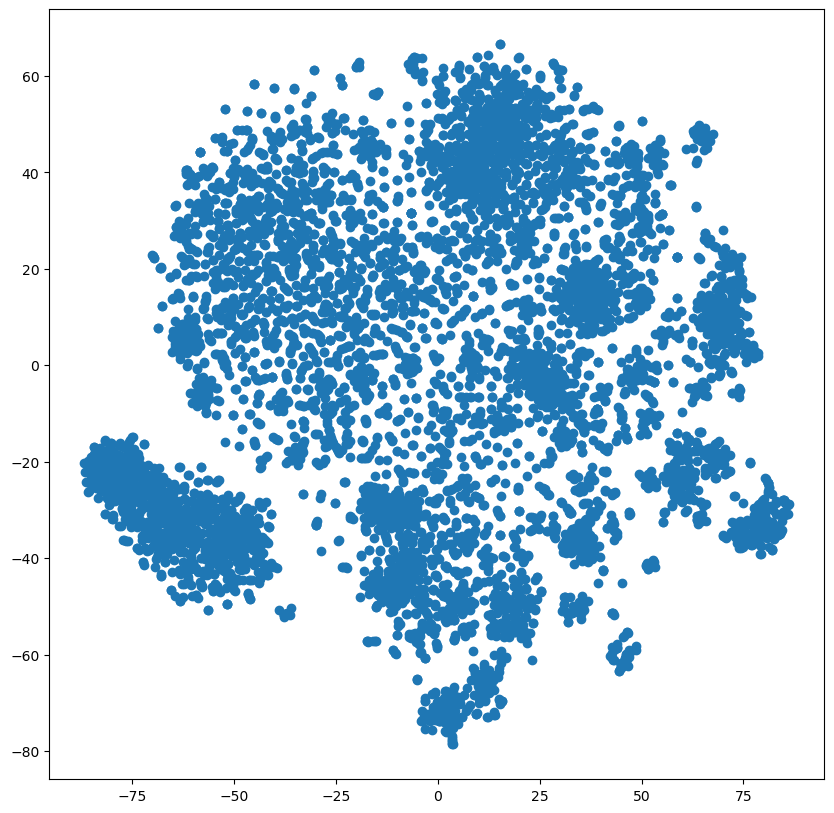

In [86]:
plt.figure(figsize=(10,10))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

X = phrase_embed_matrix
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [ ]:
for i in range(indices.shape[0]):
  for j in range(indices.shape[1]):
    if j == 0:
      print(f'({phrases[indices[i,j]]})', end=', ')
      continue
    print(phrases[indices[i,j]], end=', ')
  print()
  print()

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
X = phrase_embed_matrix

# Perform K-means clustering
kmeans = KMeans(n_clusters=20)
kmeans.fit(X)

# Retrieve the cluster labels
labels = kmeans.labels_

# Create a dictionary to store clusters
clusters = {}
for i, label in enumerate(labels):
  if label not in clusters:
      clusters[label] = []
  clusters[label].append(phrases[i])

In [ ]:
# Print the clusters
for label, phrases1 in clusters.items():
    print(f"Cluster {label}:")
    for phrase1 in phrases1:
        print(phrase1)
    print()

In [30]:
docs = phrases

In [31]:
len(docs)

7516

In [32]:
phrase_embed_matrix.shape

torch.Size([7516, 768])

In [33]:
topic_model = BERTopic().fit(docs, phrase_embed_matrix.numpy())

In [ ]:

Visualize Documents 	.visualize_documents()
Visualize Document Hierarchy 	.visualize_hierarchical_documents()
Visualize Topic Tree 	.get_topic_tree(hierarchical_topics)
Visualize Topic Probability Distribution 	.visualize_distribution(probs[0])
Visualize Topics over Time 	.visualize_topics_over_time(topics_over_time)
Visualize Topics per Class 	.visualize_topics_per_class(topics_per_class)

In [34]:
topic_model.visualize_barchart().show()

In [35]:
topic_model.visualize_topics().show()

In [47]:
topic_model.visualize_documents(docs, embeddings=phrase_embed_matrix)

In [49]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(phrase_embed_matrix)

In [50]:
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [42]:
hierarchical_topics = topic_model.hierarchical_topics(docs)

100%|██████████| 131/131 [00:01<00:00, 86.50it/s]


In [46]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [37]:
topic_model.visualize_heatmap()

In [38]:
topic_model.visualize_term_rank()

In [51]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)

In [53]:
# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(docs[2], topic_token_distr[1])
df

,could,be,worn
39_does_not_represent_do,0.450,0.450,0.450
70_does_not_affect_exit,0.269,0.269,0.269


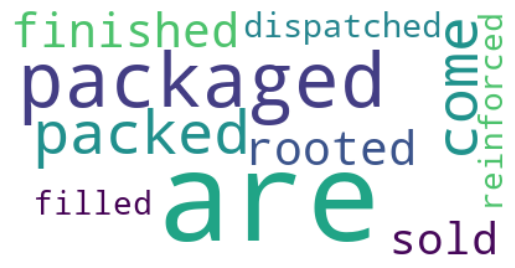

In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=3)